In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored
from google.oauth2 import service_account
import pandas_gbq as gbq


In [34]:
# df = pd.read_csv('dataset/X_Y_merged.csv')
# df.head()
credentials_path = 'token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

project_id = 'capstone-398012'
dataset_id = 'capstone'
table_id = "filled_table_2"

from pandas_gbq import read_gbq

query = f"""
SELECT *
FROM `{project_id}.{dataset_id}.{table_id}`

"""

# Authenticate and read data from BigQuery into a DataFrame
df = read_gbq(query, project_id=project_id, dialect='standard')
df.head()


Downloading: 100%|██████████|


,CompanyNumber,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,ni2tatrend_notNA,sigma_notNA,sizetrend_notNA,sizelevel_notNA,DTDmedianNonFin_notNA,liqfinlevel_notNA,lqfintrend_notNA,StkIndx_notNA,DTDmedianFin_notNA,STInt_notNA
0,27393,1988,1,0.093809,0.011518,8.261242,-0.019985,0.293348,-0.006930,0.007797,...,0,0,1,1,0,1,1,0,1,1
1,27743,1988,1,0.143173,0.011518,0.002370,0.078686,0.027940,0.020074,-0.010069,...,0,0,1,1,0,1,1,0,1,1
2,27810,1988,1,0.162171,0.011518,8.199871,0.009959,-0.107092,-0.021722,0.004038,...,0,0,1,1,0,1,1,0,1,1
3,27829,1988,1,0.093809,0.011518,3.231864,0.009803,0.566271,0.017915,0.002784,...,0,0,1,1,0,1,1,0,1,1
4,27958,1988,1,0.093809,0.011518,7.566077,0.031028,-0.056320,-0.010913,0.009707,...,0,0,1,1,0,1,1,0,1,1


In [36]:
# df['transformed_status'] = df['EventType'].map(lambda x : 1 if x == 1 else 0)
# df['transformed_status'] = df['EventType']
df['transformed_year'] = df['yyyy'].apply(lambda x: x - 1988)

# Data preprocessing
X = df.drop(['yyyy','mm','EventDate','EventType', 'transformed_year'], axis=1)  # Features

# X = df.drop(['EventDate_notNA','EventType', 'Sector_Number_notNA', 'Exchange_notNA'], axis=1)  # Features
y = df['EventType']  # Target

df.head()

,CompanyNumber,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,sigma_notNA,sizetrend_notNA,sizelevel_notNA,DTDmedianNonFin_notNA,liqfinlevel_notNA,lqfintrend_notNA,StkIndx_notNA,DTDmedianFin_notNA,STInt_notNA,transformed_year
0,27393,1988,1,0.093809,0.011518,8.261242,-0.019985,0.293348,-0.006930,0.007797,...,0,1,1,0,1,1,0,1,1,0
1,27743,1988,1,0.143173,0.011518,0.002370,0.078686,0.027940,0.020074,-0.010069,...,0,1,1,0,1,1,0,1,1,0
2,27810,1988,1,0.162171,0.011518,8.199871,0.009959,-0.107092,-0.021722,0.004038,...,0,1,1,0,1,1,0,1,1,0
3,27829,1988,1,0.093809,0.011518,3.231864,0.009803,0.566271,0.017915,0.002784,...,0,1,1,0,1,1,0,1,1,0
4,27958,1988,1,0.093809,0.011518,7.566077,0.031028,-0.056320,-0.010913,0.009707,...,0,1,1,0,1,1,0,1,1,0


c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\nonparametric.py:200: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.cumsum(ratio_var))


Text(0.5, 0, 'time $t$')

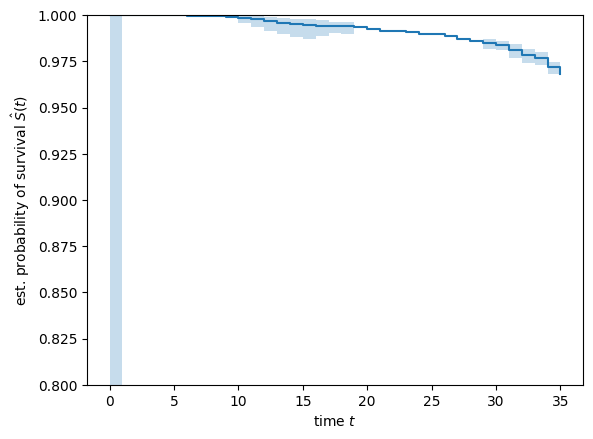

In [38]:
# Kaplan meier estimator
df['status_boolean'] = df['EventType'].map(lambda x : True if x == 1.0 or x == 2.0 else False)

time, survival_prob, conf_int = kaplan_meier_estimator(
    df["status_boolean"], df["transformed_year"], conf_type="log-log"
)

plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0.8, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [55]:
# Data preprocessing
# X = df.drop(['yyyy', 'EventDate_notNA','Event_type', 'Sector_Number_notNA', 'Exchange_notNA', 'transformed_status','transformed_year', 'status_boolean'], axis=1)  # Features
df_new = df.copy()
# df_new.dropna(inplace=True)

X = df_new.drop(['EventDate','EventType','transformed_year', 'status_boolean', 'yyyy', 'mm'], axis=1)  # Features
y = np.array(list(zip(df_new['status_boolean'], df_new['transformed_year'])), dtype=[('event', bool), ('time', int)])

# encoder = OneHotEncoder()
# X_encoded = encoder.fit_transform(X)

# Imputing Nan
# X_encoded = X_encoded.fillna(0)

# Scaling
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
X

,CompanyNumber,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,...,ni2tatrend_notNA,sigma_notNA,sizetrend_notNA,sizelevel_notNA,DTDmedianNonFin_notNA,liqfinlevel_notNA,lqfintrend_notNA,StkIndx_notNA,DTDmedianFin_notNA,STInt_notNA
0,27393,0.093809,0.011518,8.261242,-0.019985,0.293348,-0.006930,0.007797,0.000039,3.751873,...,0,0,1,1,0,1,1,0,1,1
1,27743,0.143173,0.011518,0.002370,0.078686,0.027940,0.020074,-0.010069,0.000285,-1.028263,...,0,0,1,1,0,1,1,0,1,1
2,27810,0.162171,0.011518,8.199871,0.009959,-0.107092,-0.021722,0.004038,0.000024,4.597807,...,0,0,1,1,0,1,1,0,1,1
3,27829,0.093809,0.011518,3.231864,0.009803,0.566271,0.017915,0.002784,0.000035,0.163936,...,0,0,1,1,0,1,1,0,1,1
4,27958,0.093809,0.011518,7.566077,0.031028,-0.056320,-0.010913,0.009707,0.000125,4.722356,...,0,0,1,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614302,203822,-0.196544,0.005723,10.695591,-9.240781,0.000000,0.000000,-0.000044,-0.021061,-0.566277,...,1,1,1,1,1,1,1,1,1,1
2614303,205028,-0.196544,0.005723,3.384610,-1.715269,0.000000,0.000000,0.003363,-0.007010,-0.305522,...,1,1,1,1,1,1,1,1,1,1
2614304,205656,-0.196544,0.005723,114.654533,14.933724,0.000000,0.000000,0.004082,-0.000269,-0.254153,...,1,1,1,1,1,1,1,1,1,1
2614305,206226,-0.196544,0.005723,74.234131,14.933724,0.000000,0.000000,0.005301,-0.003924,-0.665688,...,1,1,1,1,1,1,1,1,1,1


In [59]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)


LinAlgError: Matrix is singular.

In [121]:
prediction = estimator.predict(X_test)

y_df = pd.DataFrame(y_test)

result = concordance_index_censored(y_df['event'], y_df['time'], prediction)
# or estimator.score(X_test, y_test)
print(f"Concordance Index: {result[0]}")

Concordance Index: 0.7607796777918293
